# Dataset and Benchmark creation with `Polaris`
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <07_01_polaris_adme-fang-1_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib
import numpy as np

import datamol as dm

# polaris benchmark
from polaris.benchmark import (
    SingleTaskBenchmarkSpecification,
    MultiTaskBenchmarkSpecification,
)

# polaris hub
from polaris.utils.types import HubOwner

# utils
root = pathlib.Path("__file__").absolute().parents[3]
os.chdir(root)
sys.path.insert(0, str(root))
from utils.docs_utils import load_readme

In [2]:
# Get the owner and organization

org = "novartis"
data_name = "CYP"
dirname = dm.fs.join(root, f"org-{org}", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/{data_name}"

dataset_name = "novartis_cyp3a4-v1"

owner = HubOwner(slug=org, type="organization")
owner

HubOwner(slug='novartis', external_id=None, type='organization')

In [3]:
BENCHMARK_DIR = f"{gcp_root}/benchmarks"
DATASET_JSON = "gs://polaris-public/polaris-recipes/org-novartis/CYP/datasets/novartis_cyp3a4-v1/dataset.json"

FIGURE_DIR = f"{gcp_root}/figures"

## Load existing dataset object



In [4]:
# Load the saved Dataset
from polaris.dataset import Dataset

dataset = Dataset.from_json(DATASET_JSON)

In [17]:
dataset

TypeError: Object of type PosixPath is not JSON serializable

name novartis_cyp3a4-v1 description CYP3A4 Time-Dependent Inhibition data released by Novartis tags ADME user_attributes year 2024 owner novartis polaris_version dev default_adapters zarr_root_path None readme ![CYP](https://pubs.acs.org/cms/10.1021/acs.chemrestox.3c00305/asset/images/medium/tx3c00305_0006.gif)

## Background
Cytochrome P450 (CYP) enzymes are membrane-bound hemeproteins that play a key role in metabolism of drugs and xenobiotics. Most drugs are mainly metabolized by cytochrome P450 (CYP450), which can lead to drug–drug interactions (DDI). Specifically, time-dependent inhibition (TDI) of CYP3A4 isoenzyme has been associated with clinically relevant DDI. To overcome potential DDI issues, high-throughput in vitro assays were established to assess the TDI of CYP3A4 during the discovery and lead optimization phases.

## Assay information
To assess time-dependent inhibition (TDI), inactivation rate constants (kobs values) were determined. For this purpose, test articles (10 μM) were dispensed to 96-well plates, and the preincubation was started by the addition of human liver microsomes supplemented with reduced nicotinamide adenine dinucleotide phosphate (NADPH). After 0, 7, 16, and 32 min, the residual CYP3A activity was determined by the addition of midazolam (including d4-1-hydroxy-midazolam as internal standard) and incubated for six additional minutes before being stopped by the addition of acetonitrile. The supernatants were analyzed for the CYP3A4 selective metabolites 1-hydroxymidazolam and d4-1-hydroxymidazolam using liquid chromatography–mass spectrometry (LC–MS). The time-dependent CYP3A enzyme activity was calculated using the normalized AREA-ratios of 1-hydroxymidazolam to the internal standard and plotted over the preincubation time. The first-order inactivation rate constant kobs was determined by a 1-parameter fit using a range of 80% and a background of 20%. The percentage of reversible inhibition (%inh-rev) was calculated by the AREA-ratio at a preincubation time of 0 min in relation to the AREA-ratio of the control containing dimethyl sulfoxide (DMSO) only. In the case of a strong reversible inhibition (%inh-rev >50%), no kobs values were calculated.

## Description of readout:
- **log_kobs**: Log-transformed(base 10) inactivation rate($K_{obs}$). 

## Data resource

**Raw data**: 
- Training set: https://pubs.acs.org/doi/suppl/10.1021/acs.chemrestox.3c00305/suppl_file/- tx3c00305_si_002.xlsx 
- Test set: https://pubs.acs.org/doi/suppl/10.1021/acs.chemrestox.3c00305/suppl_file/tx3c00305_si_003.xlsx

**Processed data**: gs://polaris-public/polaris-recipes/org-novartis/CYP/data/raw/train_test.parquet annotations MOL_smiles is_pointer False modality MOLECULE description Molecule SMILES string user_attributes dtype object log_kobs is_pointer False modality UNKNOWN description Log unit of TDI CYP3A4 inactivation. user_attributes dtype float64 CLS_log_kobs is_pointer False modality UNKNOWN description Three-class binning on TDI CYP3A4 inactivation 0.01 and 0.025. user_attributes dtype float64 pIC50_CYP3A4 is_pointer False modality UNKNOWN description Reversible CYP3A4 inhibition pIC50 values. user_attributes dtype float64 pIC50_CYP2C9 is_pointer False modality UNKNOWN description Reversible CYP2C9 inhibition pIC50 values. user_attributes dtype float64 pIC50_CYP2D6 is_pointer False modality UNKNOWN description Reversible CYP2D6 inhibition pIC50 values. user_attributes dtype float64 split is_pointer False modality UNKNOWN description Train and test splitting from the original publication doi.org/10.1021/acs.chemrestox.3c00305 user_attributes dtype object source https://pubs.acs.org/doi/10.1021/acs.chemrestox.3c00305 license CC-BY-4.0 curation_reference https://github.com/polaris-hub/polaris-recipes/org-Polaris/org-Novartis/CYP/00_CYP3A4_data_processing.ipynb cache_dir /Users/lu.zhu/Library/Caches/polaris/datasets/06358093-09c2-40ea-8784-659a49b24875 md5sum dcefee6bdae2a0c8224ea14a54e8b7ad artifact_id nova

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

In [6]:
dataset.columns

['MOL_smiles',
 'log_kobs',
 'CLS_log_kobs',
 'pIC50_CYP3A4',
 'pIC50_CYP2C9',
 'pIC50_CYP2D6',
 'split']

In [7]:
mol_col = "MOL_smiles"
data_cols = [
    "log_kobs",
    "cl" "pIC50_CYP3A4",
    "pIC50_CYP2C9",
    "pIC50_CYP2D6",
]

## Create a Benchmark as in published paper
The train/test sets are pre-defined in `doi.org/10.1021/acs.chemrestox.3c00305`

In [8]:
train_split = dataset.table.query("split == 'train'").index.values
test_split = dataset.table.query("split == 'test'").index.values

### Check distribution of train/test set in the chemical space

  0%|          | 0/16740 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


'https://storage.googleapis.com/polaris-public/polaris-recipes/org-novartis/CYP/figures/paper_split_chemspace.png'

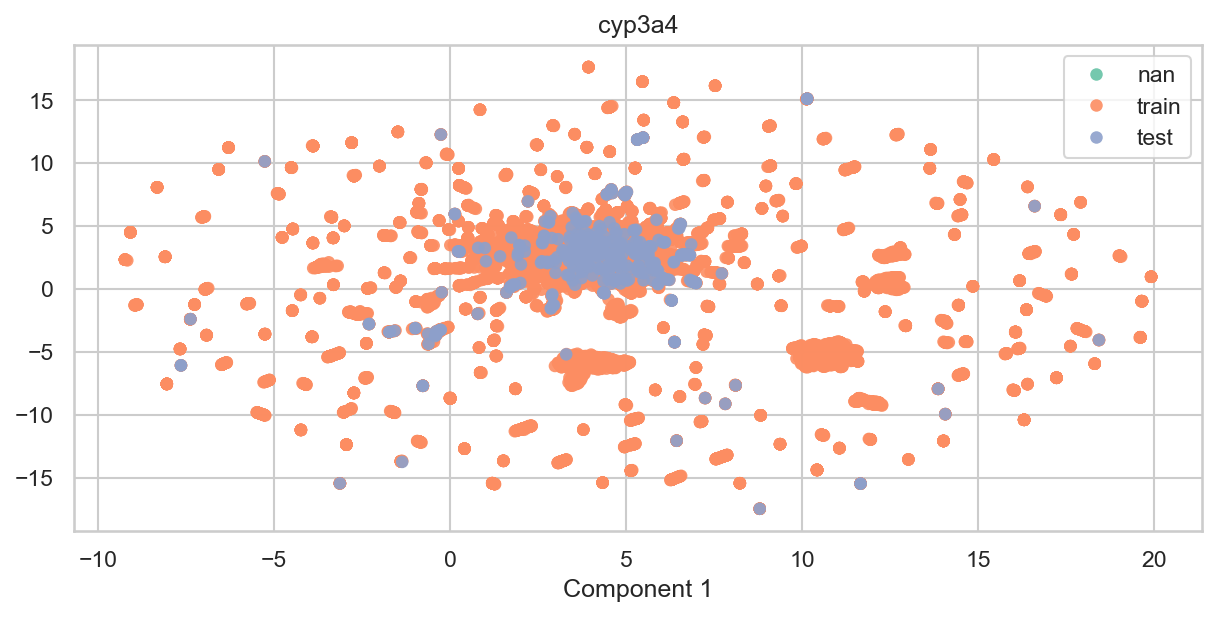

In [9]:
from utils.docs_utils import visualize_split_chemspace

fig = visualize_split_chemspace(
    mols=dataset.table[mol_col].to_list(),
    train_test_dict={"cyp3a4": (train_split, test_split)},
)

# export the figure to remote path
from utils.auroris_utils import save_image

save_image(fig, dm.fs.join(FIGURE_DIR, f"paper_split_chemspace.png"))

## Single classification task on `CLS_log_kobs`

In [13]:
benchmark_name = "adme-novartis-cyp3a4-cls"

benchmark_cls = SingleTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=["CLS_log_kobs"],
    target_types={"CLS_log_kobs": "classification"},
    input_cols=mol_col,
    split=(train_split, test_split),
    main_metric="balanced_accuracy",
    metrics=["balanced_accuracy"],
    tags=["ADME", "SingleTask"],
    owner=owner,
    description=f"Single classification task benchmark for CYP3A4 {data_cols[0]}",
)
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark_cls.to_json(BENCHMARK_SAVE_DIR)
print(path)

2024-07-15 15:54:51.460 | INFO     | polaris._mixins:md5sum:27 - Computing the checksum. This can be slow for large datasets.


gs://polaris-public/polaris-recipes/org-novartis/CYP/benchmarks/adme-novartis-cyp3a4-cls/benchmark.json


In [14]:
# Upload to hub
benchmark_cls.upload_to_hub(owner=owner, access="private")

2024-07-15 15:54:56.829 | SUCCESS  | polaris.hub.client:upload_benchmark:675 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/novartis/adme-novartis-cyp3a4-cls


{'id': 'xJt7pdyjtxt97a3ag7Fky',
 'createdAt': '2024-07-15T19:54:56.558Z',
 'deletedAt': None,
 'name': 'adme-novartis-cyp3a4-cls',
 'slug': 'adme-novartis-cyp3a4-cls',
 'description': 'Single classification task benchmark for CYP3A4 log_kobs',
 'tags': ['ADME', 'SingleTask'],
 'userAttributes': {},
 'access': 'private',
 'isCertified': False,
 'polarisVersion': 'dev',
 'readme': '',
 'state': 'ready',
 'ownerId': 'yLurE6WfGoFvJX8EHoCpA',
 'creatorId': 'NKnaHGybLqwSHcaMEHqfF',
 'datasetId': '34v8XZcV0MPPdGGP2FalP',
 'targetCols': ['CLS_log_kobs'],
 'inputCols': ['MOL_smiles'],
 'md5Sum': '5f7b252e6b6f36eee6bc5f5701a1f4a5',
 'metrics': ['balanced_accuracy'],
 'mainMetric': 'balanced_accuracy',
 'split': [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,

## Single regression task on `log Kobs`

In [15]:
benchmark_name = "adme-novartis-cyp3a4-reg"
target_col = "log_kobs"

benchmark_reg = SingleTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=target_col,
    target_types={target_col: "regression"},
    input_cols=mol_col,
    split=(train_split, test_split),
    main_metric="absolute_average_fold_error",
    metrics=[
        "absolute_average_fold_error",
        "mean_absolute_error",
        "mean_squared_error",
        "r2",
        "spearmanr",
        "pearsonr",
        "explained_var",
    ],
    tags=["ADME", "SingleTask"],
    owner=HubOwner(user_id="Novartis", slug="novartis"),
    description=f"Single regression task benchmark for CYP3A4 {target_col}",
)
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark_reg.to_json(BENCHMARK_SAVE_DIR)
print(path)

2024-07-15 15:55:21.091 | INFO     | polaris._mixins:md5sum:27 - Computing the checksum. This can be slow for large datasets.


gs://polaris-public/polaris-recipes/org-novartis/CYP/benchmarks/adme-novartis-cyp3a4-reg/benchmark.json


In [16]:
# Upload to hub
benchmark_reg.upload_to_hub(owner=owner, access="private")

2024-07-15 15:55:25.530 | SUCCESS  | polaris.hub.client:upload_benchmark:675 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/novartis/adme-novartis-cyp3a4-reg


{'id': 'Vs2gPPjkSQbt4SbBkl5qw',
 'createdAt': '2024-07-15T19:55:25.069Z',
 'deletedAt': None,
 'name': 'adme-novartis-cyp3a4-reg',
 'slug': 'adme-novartis-cyp3a4-reg',
 'description': 'Single regression task benchmark for CYP3A4 log_kobs',
 'tags': ['ADME', 'SingleTask'],
 'userAttributes': {},
 'access': 'private',
 'isCertified': False,
 'polarisVersion': 'dev',
 'readme': '',
 'state': 'ready',
 'ownerId': 'yLurE6WfGoFvJX8EHoCpA',
 'creatorId': 'NKnaHGybLqwSHcaMEHqfF',
 'datasetId': '34v8XZcV0MPPdGGP2FalP',
 'targetCols': ['log_kobs'],
 'inputCols': ['MOL_smiles'],
 'md5Sum': '4d027ad14ddb8528302d771cdd3db442',
 'metrics': ['absolute_average_fold_error',
  'mean_absolute_error',
  'mean_squared_error',
  'r2',
  'spearmanr',
  'pearsonr',
  'explained_var'],
 'mainMetric': 'absolute_average_fold_error',
 'split': [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
 

## Multitask regression task and evaluate on `log Kobs` three classes
(This benchmark involves training a regression model and evaluating it using classification metrics. The implementation is currently under development.)

In [1]:
# benchmark_name = "adme-novartis-cyp-multitask-reg"
# target_cols = ["log_kobs", "pIC50_CYP3A4", "pIC50_CYP2C9", "pIC50_CYP2D6"]

# benchmark_multi_reg = MultiTaskBenchmarkSpecification(
#     name=benchmark_name,
#     dataset=dataset,
#     target_cols=target_cols,
#     target_types={target_col: "regression" for target_col in target_cols},
#     input_cols=mol_col,
#     split=(train_split, test_split),
#     main_metric="balanced_accuracy",
#     metrics=["absolute_average_fold_error", "balanced_accuracy"],
#     target_binning={"log_kobs": ([np.log10(0.01), np.log10(0.025)], "ascending")},
#     tags=["ADME", "MultiTask"],
#     owner=HubOwner(user_id="Novartis", slug="novartis"),
#     description=f"Multitask regression task benchmark for CYP3A4, CYP2C9, CYP2D6 ",
# )
# BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
# path = benchmark_multi_reg.to_json(BENCHMARK_SAVE_DIR)
# print(path)

In [15]:
# # upload to polaris hub
# from polaris.hub.client import PolarisHubClient
# client = PolarisHubClient()
# client.login()
# client.upload_benchmark(benchmark=benchmark_multi_reg, access="private", owner=owner)

2024-07-10 01:48:20.586 | INFO     | polaris.hub.client:login:285 - You are already logged in to the Polaris Hub as  (lu@valencediscovery.com). Set `overwrite=True` to force re-authentication.
2024-07-10 01:48:21.504 | SUCCESS  | polaris.hub.client:upload_benchmark:675 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/novartis/adme-novartis-cyp-multitask-reg


{'id': 'T5MhGL6FpyWmvQXoBdjK2',
 'createdAt': '2024-07-10T05:48:21.346Z',
 'deletedAt': None,
 'name': 'adme-novartis-cyp-multitask-reg',
 'slug': 'adme-novartis-cyp-multitask-reg',
 'description': 'Multitask regression task benchmark for CYP3A4, CYP2C9, CYP2D6 ',
 'tags': ['ADME', 'MultiTask'],
 'userAttributes': {},
 'access': 'private',
 'isCertified': False,
 'polarisVersion': 'dev',
 'readme': '',
 'state': 'ready',
 'ownerId': 'yLurE6WfGoFvJX8EHoCpA',
 'creatorId': 'NKnaHGybLqwSHcaMEHqfF',
 'datasetId': 'cYlWyrr7wFiTiTHKZt9v9',
 'targetCols': ['log_kobs', 'pIC50_CYP3A4', 'pIC50_CYP2C9', 'pIC50_CYP2D6'],
 'inputCols': ['MOL_smiles'],
 'md5Sum': 'e26126955cb449e37861883fbc7020c5',
 'metrics': ['absolute_average_fold_error', 'balanced_accuracy'],
 'mainMetric': 'balanced_accuracy',
 'split': [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
  